In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("archive/Stocks/aapl.us.txt")
df = df.iloc[:,:-1]

# Calculate the Moving Average for Open price over the last 5 days
df['MA_Open_5'] = df['Open'].rolling(5).mean()

# Calculate the Moving Average for Close price over the last 5 days
df['MA_Close_5'] = df['Close'].rolling(5).mean()

# Calculate the Moving Average for Volume over the last 5 days
df['MA_Volume_5'] = df['Volume'].rolling(5).mean()

# Calculate the Relative Strength Index over the last 14 days
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# Calculate the Commodity Channel Index over the last 20 days
tp = (df['High'] + df['Low'] + df['Close']) / 3
ma = tp.rolling(20).mean()
dev = (tp - ma).abs().rolling(20).mean()
cci = (tp - ma) / (0.015 * dev)
df['CCI_20'] = cci

# Calculate the Exponential Moving Average for Close price over the last 10 days
df['EMA_Close_10'] = df['Close'].ewm(span=10, adjust=False).mean()

# Calculate the Bollinger Bands over the last 20 days
sma = df['Close'].rolling(20).mean()
std = df['Close'].rolling(20).std()
df['BB_upper_20'] = sma + 2 * std
df['BB_lower_20'] = sma - 2 * std

# Fill null values with mean for all columns except 'Date', since nulls will happen for the first
# Few rows where rolling average cannot be computed
df[df.columns.difference(['Date'])] = df[df.columns.difference(['Date'])].apply(lambda x: x.fillna(x.mean()))


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Split the data into training and test sets based on a cutoff date
lstm_data = df.copy()
lstm_data['Date'] = pd.to_datetime(lstm_data['Date'])


cutoff_date = pd.to_datetime('2014-01-01')
train = lstm_data[lstm_data['Date'] < cutoff_date]
test = lstm_data[lstm_data['Date'] >= cutoff_date]

# Split the training and test sets into features and target
X_train = train.drop(['Date', 'Close'], axis=1)
y_train = train['Close']
X_test = test.drop(['Date', 'Close'], axis=1)
y_test = test['Close']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the features for use in an LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 12)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)


Epoch 1/50
231/231 [==============================] - 6s 4ms/step - loss: 332.0166
Epoch 2/50
231/231 [==============================] - 1s 4ms/step - loss: 193.8117
Epoch 3/50
231/231 [==============================] - 1s 4ms/step - loss: 137.4366
Epoch 4/50
231/231 [==============================] - 1s 4ms/step - loss: 98.2534
Epoch 5/50
231/231 [==============================] - 1s 4ms/step - loss: 73.2543
Epoch 6/50
231/231 [==============================] - 1s 4ms/step - loss: 53.9932
Epoch 7/50
231/231 [==============================] - 1s 4ms/step - loss: 40.0349
Epoch 8/50
231/231 [==============================] - 1s 4ms/step - loss: 30.8243
Epoch 9/50
231/231 [==============================] - 1s 4ms/step - loss: 24.7894
Epoch 10/50
231/231 [==============================] - 1s 4ms/step - loss: 19.7517
Epoch 11/50
231/231 [==============================] - 1s 4ms/step - loss: 16.7560
Epoch 12/50
231/231 [==============================] - 1s 4ms/step - loss: 12.4284
Epoch 13/5

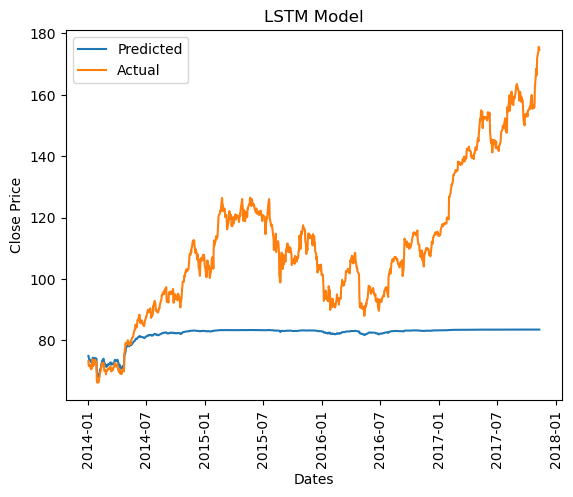

MSE: 1331.1050273104752
MAE: 29.37819334709277
RMSE: 36.48431207122419


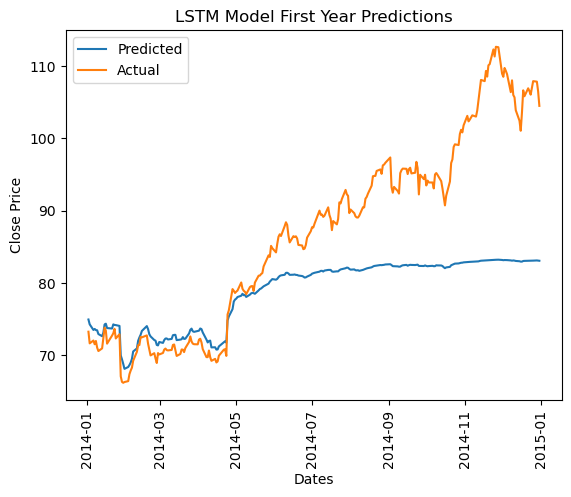

MSE: 141.97173919934184
MAE: 8.784464380657862
RMSE: 11.91518943195373


In [14]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot




dates = lstm_data[lstm_data['Date'] >= cutoff_date]['Date']
plt.plot(dates, y_pred, label='Predicted')
plt.plot(dates, y_test, label='Actual')
plt.title("LSTM Model")
plt.xlabel("Dates")
plt.ylabel("Close Price")
pyplot.setp(pyplot.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.legend()
plt.show()

# evaluate forecasts
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')




#dates = lstm_data[lstm_data['Date'] >= cutoff_date]['Date']
#dates = lstm_data.query('Date >= "2014-01-01" and Date < "2015-01-01"')['Date']
cutoff_date = pd.to_datetime('2014-01-01')
one_year_date = pd.to_datetime('2015-01-01')
dates = lstm_data.loc[(lstm_data['Date'] >= cutoff_date) & (lstm_data['Date'] < one_year_date)]['Date']
plt.plot(dates, y_pred[:dates.size], label='Predicted')
plt.plot(dates, y_test[:dates.size], label='Actual')
plt.title("LSTM Model First Year Predictions")
plt.xlabel("Dates")
plt.ylabel("Close Price")
pyplot.setp(pyplot.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.legend()
plt.show()

mae = mean_absolute_error(y_test[:dates.size], y_pred[:dates.size])
mse = mean_squared_error(y_test[:dates.size], y_pred[:dates.size])
rmse = sqrt(mse)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')